# Restauração de Imagens - Mínimos Quadrados

## Bibliotecas utilizadas

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from math import sqrt
from scipy.signal import convolve2d
from skimage import color, data, measure, restoration

## Funções

### Raíz Quadrada do Erro Médio (Root Mean Squared Error - RMSE)

In [ ]:
def RMSE(image, corrupted_image):
  errors = []
  N = image.shape[0] * image.shape[1]
  sum = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      error = (int(image[i][j]) - int(corrupted_image[i][j]))**2
      sum += error
      errors.append(error)
  square_root = sqrt(sum)
  rmse = square_root/N
  return rmse

### getMotionDsf()

In [ ]:
def getMotionDsf(shape, angle, dist):
  xCenter = (shape[0] - 1) / 2
  yCenter = (shape[1] - 1) / 2
  sinVal = np.sin(angle * np.pi / 180)
  cosVal = np.cos(angle * np.pi / 180)
  PSF = np.zeros(shape)
  for i in range(dist):
    xOffset = round(sinVal * i)
    yOffset = round(cosVal * i)
    PSF[int(xCenter - xOffset), int(yCenter + yOffset)] = 1
  return PSF / PSF.sum()

### makeBlurred()

In [ ]:
def makeBlurred(image, PSF, eps):
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF) + eps
  fftBlur = np.fft.ifft2(fftImg * fftPSF)
  fftBlur = np.abs(np.fft.fftshift(fftBlur))
  return fftBlur

### getPuv()

In [ ]:
def getPuv(image):
  h, w = image.shape[:2]
  hPad, wPad = h - 3, w - 3
  pxy = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  pxyPad = np.pad(pxy, ((hPad//2, hPad - hPad//2), (wPad//2, wPad - wPad//2)), mode='constant')
  fftPuv = np.fft.fft2(pxyPad)
  return fftPuv

### leaastSquareFilter()

In [ ]:
def leastSquareFilter(image, PSF, eps, gamma=0.01):
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF)
  conj = fftPSF.conj()
  fftPuv = getPuv(image)
  Huv = conj / (np.abs(fftPSF)**2 + gamma * (np.abs(fftPuv)**2))
  ifftImg = np.fft.ifft2(fftImg * Huv)
  ifftShift = np.abs(np.fft.fftshift(ifftImg))
  imgLSFilter = np.uint8(cv2.normalize(np.abs(ifftShift), None, 0, 255, cv2.NORM_MINMAX))
  return imgLSFilter

In [ ]:
def RMSE_evaluation(original_image, restored_images):
  return [RMSE(original_image, restored_image*255.0) for restored_image in restored_images]

In [ ]:
def resize_img(img, scale):
  width = int(img.shape[1]*scale/100)
  height = int(img.shape[0]*scale/100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

## Imagem orignal

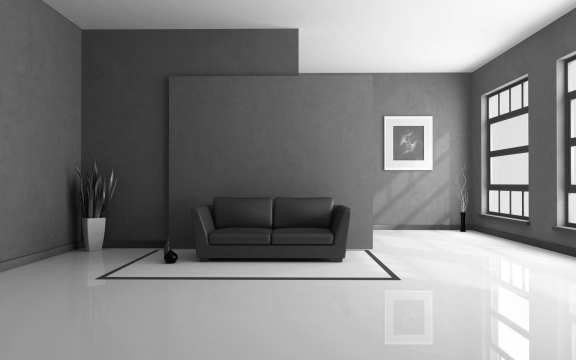

In [ ]:
image = resize_img(cv2.imread('rosso', 0), 30)
cv2_imshow(image)

## Degradação da imagem

In [ ]:
hImg, wImg = image.shape[:2]
PSF = getMotionDsf((hImg, wImg), 45, 100)

In [ ]:
PSF = getMotionDsf((hImg, wImg), 45, 100)
imgBlurred = np.abs(makeBlurred(image, PSF, 1e-6))

scale = 0.01
noisy = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale, size=imgBlurred.shape)
imgBlurNoisy = imgBlurred + noisy

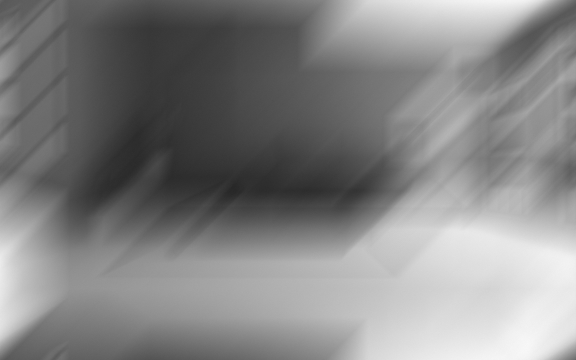

In [ ]:
cv2_imshow(imgBlurNoisy)

Algo que foi observado desde a variação dos parâmetros para o filtro bilateral é que o borramento, quando em excesso, sobrepõe todas as demais características da imagem. Em outras palavras: uma vez que aumentamos o nível de borramento da imagem até o ponto em que sua qualidade fica prejudicada, a variação de outros parâmetros, mesmo do ruído, não consegue compensar a degradação gerada pelo borramento excessivo

Essa observação indica que a degradação realizada pelo borramento é uma espécie de parâmetro absoluto, independente de qualquer outro e não afetado pela variação deles. Desta forma, para qualquer outro parâmetro, existiria um valor máximo absoluto para o parâmetro **gamma**, que pode ser considerado o valor ótimo por suavizar a imagem sem comprometer a nitidez das bordas

Levando isso em conta, podemos aplicar a estratégia de, para um parâmetro qualquer e fixo da variância do ruído (parâmetro **eps**), variar os valores do gamma e usar a RMSE para estimar para qual valor a RMSE será minimizada

Uma vez encontrado o valor ótimo para o parâmetro **gamma**, podemos avaliar a hipótese da sua independência da variação de outros parâmtros, ao variar o valor de **eps** e observar se o valor de **gamma** para o qual a RMSE é minimizada contina o mesmo que para o primeiro parâmetro testado

#### Menor valor do gamma = 0.01; maior valor do gamma = 5
#### Primeiro valor constante de eps = 0.01

In [ ]:
gamma_values = []
gamma = 0
while (True):
  gamma += 0.01
  gamma = round(gamma, 2)
  gamma_values.append(gamma)
  if (gamma == 5): break

In [ ]:
print(gamma_values)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1

In [ ]:
restored_images = [leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=gamma) for gamma in gamma_values]

In [ ]:
results = [RMSE(image,restored_image) for restored_image in restored_images]

In [ ]:
index = np.where(results == np.min(results))[0][0]
print('Menor RMSE',results[index])
print('Índice da menor RMSE', index)

Menor RMSE 0.03185271085357897
Índice da menor RMSE 0


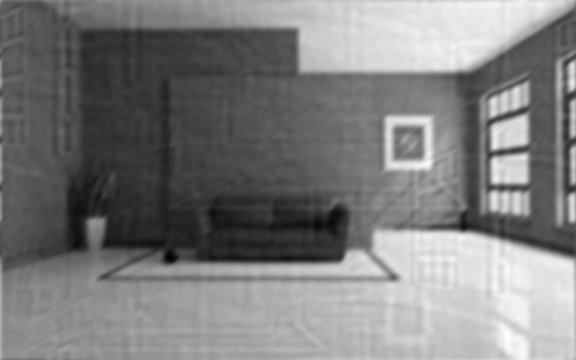

In [ ]:
cv2_imshow(leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=0.01))

In [ ]:
cv2_imshow(leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=0.02))